## Forward-running ETNP N2O box model ##

Model the time-dependent change in N2O isotopes from different substrate pools.

Created on Mon October 28th, 2019

DESCRIPTION:
    Simple time-varying model to model the expected d15N2O-alpha, d15N2O-beta, and d18O-N2O from different
    reductive substrates (nitrate and nitrite). Utilizes the known isotope values of the substrate and a
    range of expected isotope effects to model the expected isotopes of N2O.
    
STATE VARIABLES:
- n2o_14 = concentration of 14N-14N-16O, umol N/L
- n2o_15A = concentration of 14N-15N-16O, umol N/L
- n2o_15B = concentration of 15N-14N-16O, umol N/L
- n2o_16 = concentration of 14N-14N-16O, umol N/L (i.e., 1/2 O per every N2O)
- n2o_18 = concentration of 14N-14N-18O, umol N/L (i.e., 1/2 O per every N2O)

(POTENTIALLY) TIME-VARYING PARAMETERS:
- Rate constants for production and consumption of N2O
- Delta values of substrates (nitrate and nitrite)

OUTPUT:
- Value of each state variable at each time step.

@author: Colette Kelly, Stanford University (clkelly@stanford.edu)

In [1]:
import pandas as pd # dataframe management
import numpy as np # numerical functions
import matplotlib.pyplot as plt # plotting
import statsmodels.api as sm # regression analysis

from convert_delta import convert_delta # custom - convert deltas to isotope ratios
from model_functions import * # time-stepping stored in a separate function

/Users/colette/anaconda/envs/py37/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


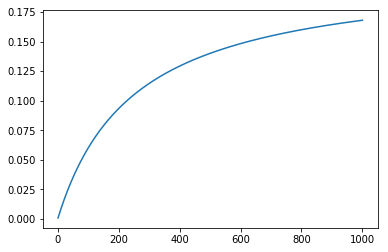

In [2]:
T = 1000
times = np.array(list(range(1,T+1))) # vector of timesteps

test1  = logfxn(time_vector=times,scaling=250,maximum=0.21,minimum=0.0)
plt.plot(times,test1)

In [3]:
test = initialize(n2o_prod_constants=[0.0,0.001,0.0,0.0,0.0,0.0])
test.n2o_cons_min

0.0

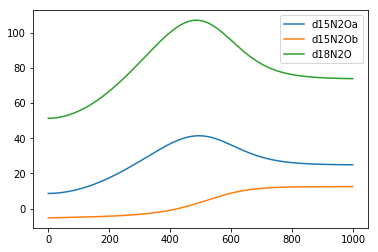

In [4]:
# run the model, simplest form
inits = initialize()
output = run_model(inits)

# plot the output
output[['d15N2Oa', 'd15N2Ob', 'd18N2O']].plot()

### Model Experiments ###

#### Can we reproduce the source endmembers observed in the near-surface maximum? ####

1. Run the model with nitrate as a source, using mean NO3- concentration and isotopes from $\sigma_{\theta}\leqslant 22.7$. Initialize with atmospheric N2O isotope values, and $[N_2O]$ at saturation
2. Run the model with nitrite as a source, using mean NO2- concentration and isotopes from $22.7\leqslant\sigma_{\theta}\leqslant25.0$. Initialize with N2O values at endpoint of nitrate run (NOT necessarily steady state values)

     [N2O]_nM    d15N2Oa    d15N2Ob
24  37.055187 -13.359874 -16.736951
       [N2O]_nM    d15N2Oa    d15N2Ob
995  149.994873 -19.579053 -26.028114
996  149.994924 -19.579033 -26.028115
997  149.994975 -19.579013 -26.028116
998  149.995025 -19.578993 -26.028116
999  149.995075 -19.578974 -26.028117


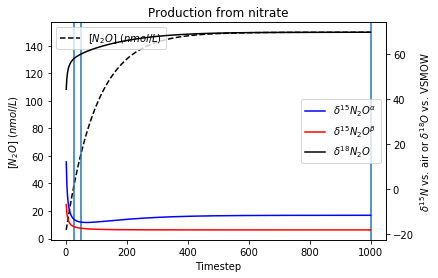

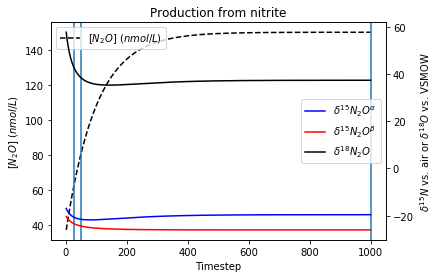

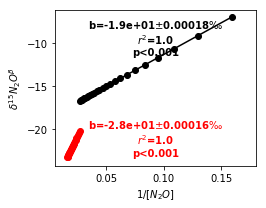

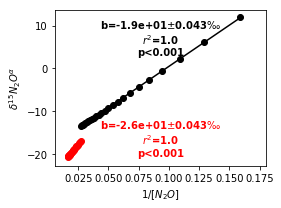

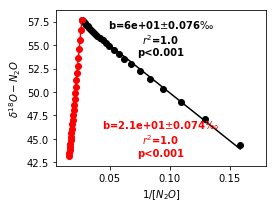

In [5]:
# SCENARIO 1

c_val = 25

alphas = [22.,6.6,  22.,0., 24.,12.,-2.,10.9, 10.,1.0]

initial_conditions = 'ATM'

### NITRATE SOURCE ###

inits = initialize(alpha_values=alphas,init_from='ATM',
                    n2o_cons_constants=[0.0,0.05,0.0],
                    n2o_prod_constants=[0.0,0.0,0.0,0.0,0.0007,0.0],
                    substrate='NO3-')

output1 = run_model(inits)

T = 1000
times = np.array(list(range(1,T+1)))

fig, ax = plt.subplots()

ax.plot(times,output1['[N2O]_nM'],color='k', linestyle='--', label='$[N_2O]\ (nmol/L)$')
ax.set_ylabel(r'$[N_2O]\ (nmol/L)$')
ax.legend(loc=2)
ax.set_xlabel('Timestep')

ax2 = ax.twinx()

ax2.plot(times,output1.d15N2Oa,color='b',label=r'$\delta^{15}N_2O^{\alpha}$')

ax2.plot(times,output1.d15N2Ob,color='r',label=r'$\delta^{15}N_2O^{\beta}$')

ax2.plot(times,output1.d18N2O,color='k',label=r'$\delta^{18}N_2O$')

ax2.set_ylabel(r'$\delta^{15}N$ vs. air or $\delta^{18}O$ vs. VSMOW')
ax2.legend()
ax2.set_title(r'Production from nitrate')
ax.axvline(25)
ax.axvline(50)
ax.axvline(1000)

plt.savefig('Figures/near_surface/200114 near surface NO3.pdf')

print(output1[output1.index<c_val][['[N2O]_nM','d15N2Oa','d15N2Ob']].tail(1) )

### NITRITE SOURCE ###

initials = output1[output1.index<c_val].tail(1) # initialize from cutoff values from nitrate run

inits = initialize(alpha_values=alphas,init_from='custom', initials=initials,
                    n2o_cons_constants=[0.0,0.05,0.0],
                    n2o_prod_constants=[0.0,0.015,0.0,0.0,0.0,0.0],
                    substrate='NO2-')

output2 = run_model(inits)

T = 1000
times = np.array(list(range(1,T+1)))

fig, ax = plt.subplots()

ax.plot(times,output2['[N2O]_nM'],color='k', linestyle='--', label='$[N_2O]\ (nmol/L)$')
ax.set_ylabel(r'$[N_2O]\ (nmol/L)$')
ax.legend(loc=2)
ax.set_xlabel('Timestep')

ax2 = ax.twinx()

ax2.plot(times,output2.d15N2Oa,color='b',label=r'$\delta^{15}N_2O^{\alpha}$')

ax2.plot(times,output2.d15N2Ob,color='r',label=r'$\delta^{15}N_2O^{\beta}$')

ax2.plot(times,output2.d18N2O,color='k',label=r'$\delta^{18}N_2O$')

ax2.set_ylabel(r'$\delta^{15}N$ vs. air or $\delta^{18}O$ vs. VSMOW')
ax2.legend()
ax2.set_title(r'Production from nitrite')
#ax2.set_ylim([-5,5])
ax.axvline(25)
ax.axvline(50)
ax.axvline(1000)


plt.savefig('Figures/near_surface/200114 near surface NO2.pdf')

print(output2[['[N2O]_nM','d15N2Oa','d15N2Ob']].tail())

################################

plotter1 = output1[output1.index<c_val]
plotter2 = output2[output2.index<c_val]

params = ['d15N2Ob','d15N2Oa','d18N2O']
labels = [r'$\delta^{15}N_2O^{\beta}$',r'$\delta^{15}N_2O^{\alpha}$',r'$\delta^{18}O-N_2O$']

for p, label in zip(params, labels): 
    
    fig, ax = plt.subplots(1,1, figsize=(4,3))

    x_init = 1./plotter1['[N2O]_nM']
    y = plotter1[p]

    ax.scatter(x_init,y, color = 'k')

    x = sm.add_constant(x_init.to_numpy(), prepend=False)
    model = sm.OLS(y,x)
    results = model.fit()
    m,b = results.params
    merr,berr = results.bse
    mp,bp = results.pvalues
    rsq = results.rsquared

    textstr = 'b={:2.2}$\pm${:2.2}$\perthousand$\n$r^2$={:.2}\np<0.001'.format(b, berr, rsq)
    ax.text(0.5, 0.95, textstr, transform=ax.transAxes,color='k',
            horizontalalignment='center', verticalalignment='top', fontweight='bold')

    linx = np.linspace(x_init.min(),x_init.max())
    ax.plot(linx,linx*m+b, color='k')

    x_init = 1./plotter2['[N2O]_nM']
    y = plotter2[p]

    ax.scatter(x_init,y, color = 'r')

    x = sm.add_constant(x_init.to_numpy(), prepend=False)
    model = sm.OLS(y,x)
    results = model.fit()
    m,b = results.params
    merr,berr = results.bse
    mp,bp = results.pvalues
    rsq = results.rsquared

    textstr = 'b={:2.2}$\pm${:2.2}$\perthousand$\n$r^2$={:.2}\np<0.001'.format(b, berr, rsq)
    ax.text(0.5, 0.05, textstr, transform=ax.transAxes,color='r',
            horizontalalignment='center', verticalalignment='bottom', fontweight='bold')
    ax.set_ylabel(label)
    ax.set_xlabel('1/[$N_2O$]')

    linx = np.linspace(x_init.min(),x_init.max())
    ax.plot(linx,linx*m+b, color='r')
    
    plt.tight_layout()
    plt.savefig('Figures/near_surface/200109 keeling reconstruction %s.pdf'%p)

#### Can we reproduce the bend in the Keeling plots based on adding consumption, alone? (I.e., not necessarily having two substrates.) 

NO - because consumption causes all of the isotopic species to increase, which is not what we see in $\delta^{15}N^{\beta}$.

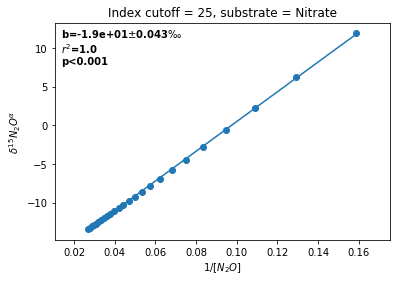

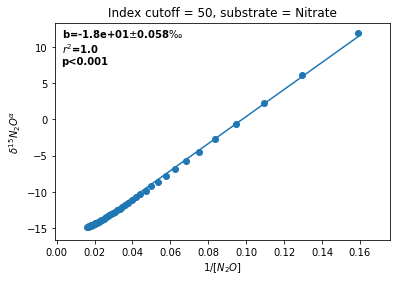

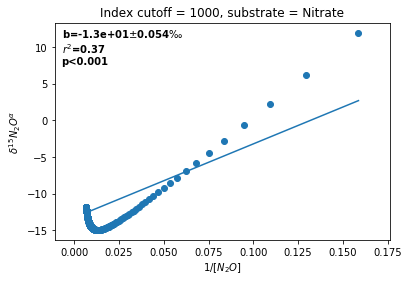

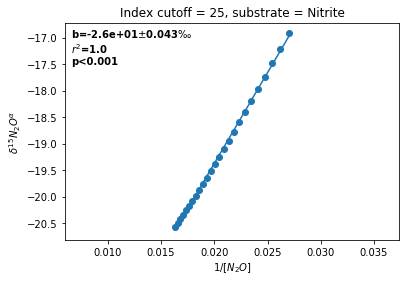

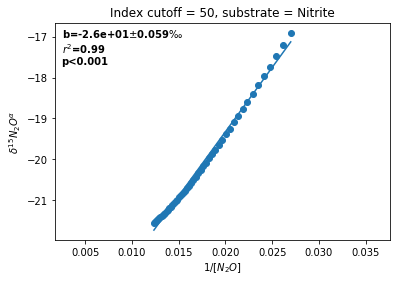

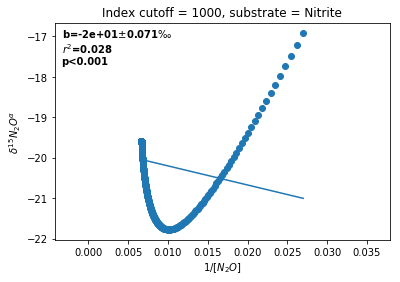

In [6]:
cutoffs = [25,50,1000]
plotting_arrays = [output1, output2]
substrates = ['Nitrate', 'Nitrite']

for count, output in enumerate(plotting_arrays):
    for c in cutoffs:

        plotter = output[output.index<c]
      #plotter = plotter[plotter['[N2O]_nM']<130] # limit to bounds of obs

        fig, ax = plt.subplots()

        x_init = 1./plotter['[N2O]_nM']
        y = plotter.d15N2Oa

        ax.scatter(x_init,y)

        x = sm.add_constant(x_init.to_numpy(), prepend=False)
        model = sm.OLS(y,x)
        results = model.fit()
        m,b = results.params
        merr,berr = results.bse
        mp,bp = results.pvalues
        rsq = results.rsquared

        textstr = 'b={:2.2}$\pm${:2.2}$\perthousand$\n$r^2$={:.2}\np<0.001'.format(b, berr, rsq)
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes,color='k',
                horizontalalignment='left', verticalalignment='top', fontweight='bold')

        linx = np.linspace(x_init.min(),x_init.max())
        ax.plot(linx,linx*m+b)
        textstr = 'Index cutoff = {:}, substrate = %s'.format(c) % substrates[count]
        ax.set_title(textstr)
        ax.set_ylabel(r'$\delta^{15}N_2O^{\alpha}$')
        ax.set_xlabel('1/[$N_2O$]')
        
        plt.savefig('Figures/sensitivity_tests/200109 %s.pdf' % textstr)

#### Can we reproduce the above-steady-state delta values in the ODZ core? ####

A nonlinear consumption curve gives us a high, transient isotope peak.

,[NO3-]_uM,d15NO3-,d18NO3-,[NO2-]_uM,d15NO2-,d18NO2-,[N2O]_nM,d15N2Oa,d15N2Ob,d18N2O,SP
999,26.5,16.3,15.0,2.0,-22.0,16.6,8.270096e-10,362.423896,35.204457,751.996139,327.219439


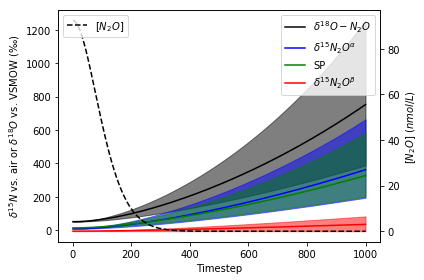

In [7]:
# run the model with a range of isotope effects for N2O consumption
# ...and plot the output, as well as print out the values at the d18O maximum

inits = initialize()

alphas1 = [22.,6.6,  22.,0., 24.,12.,-2.,10.9, 10.,1.0]
alphas2 = [22.,11.8,22.,1.6,24.,12.,-2.,20.2,10.,1.0]
alphas3 = [22.,19.8, 22.,3.4,24.,12.,-2.,30.5, 10.,1.0]

consumptionmax = 0.21
consumptionmin = 0.0
consumptionscale = 250

inits1 = initialize(alpha_values=alphas1,n2o_prod_constants=[0,0,0,0,0,0],
                    n2o_cons_constants=[consumptionscale,consumptionmax,consumptionmin],
                    substrate='NO3-')
inits2 = initialize(alpha_values=alphas2,n2o_prod_constants=[0,0,0,0,0,0],
                    n2o_cons_constants=[consumptionscale,consumptionmax,consumptionmin],
                    substrate='NO3-')
inits3 = initialize(alpha_values=alphas3,n2o_prod_constants=[0,0,0,0,0,0],
                    n2o_cons_constants=[consumptionscale,consumptionmax,consumptionmin],
                    substrate='NO3-')

output1 = run_model(inits1)
output2 = run_model(inits2)
output3 = run_model(inits3)

output1['SP'] = output1['d15N2Oa'] - output1['d15N2Ob']
output2['SP'] = output2['d15N2Oa'] - output2['d15N2Ob']
output3['SP'] = output3['d15N2Oa'] - output3['d15N2Ob']

T = 1000
times = np.array(list(range(1,T+1)))

fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.plot(times,output2.d18N2O,color='k',label=r'$\delta^{18}O-N_2O$')
ax.fill_between(times, output3.d18N2O, output1.d18N2O,
                color='k',alpha=0.5,label=None)

ax.plot(times,output2.d15N2Oa,color='b',label=r'$\delta^{15}N_2O^{\alpha}$')
ax.fill_between(times, output3.d15N2Oa, output1.d15N2Oa,
                color='b',alpha=0.5,label=None)

ax.plot(times,output2.SP,color='g',label=r'SP')
ax.fill_between(times, output3.SP, output1.SP,
                color='g',alpha=0.5,label=None)

ax.plot(times,output2.d15N2Ob,color='r',label=r'$\delta^{15}N_2O^{\beta}$')
ax.fill_between(times, output3.d15N2Ob, output1.d15N2Ob,
                color='r',alpha=0.5,label=None)

ax.set_ylabel(r'$\delta^{15}N$ vs. air or $\delta^{18}O$ vs. VSMOW ($\perthousand$)')
ax.set_xlabel('Timestep')
ax.legend()

ax2 = ax.twinx()

ax2.plot(times,output2['[N2O]_nM'],color='k', linestyle='--', label ='$[N_2O]$')
ax2.set_ylabel(r'$[N_2O]\ (nmol/L)$')
ax2.legend(loc=2)

ax2.legend(loc=2)
#ax2.set_title(r'No Production')

plt.tight_layout()

plt.savefig('Figures/ODZ/200323 forward model no production.pdf')

output2[output2.d18N2O == output2.d18N2O.max()]


source & 2.58 &  60.3 & 2.77 & 148.2 & 57.6
source & 3.04 &  47.7 & -10.1 & 139.2 & 57.9


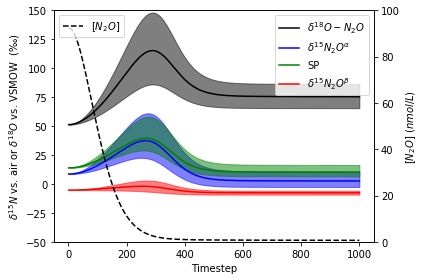

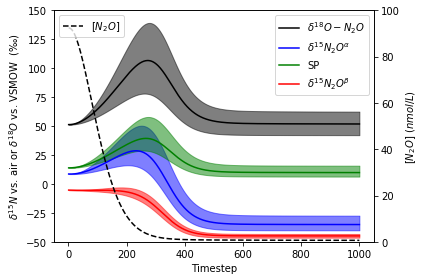

In [11]:
# run the model with a range of isotope effects for N2O consumption
# ...and plot the output, as well as print out the values at the d18O maximum

saveout = pd.DataFrame([],columns=['[NO3-]_uM', 'd15NO3-', 'd18NO3-', '[NO2-]_uM', 'd15NO2-', 'd18NO2-',
       '[N2O]_nM', 'd15N2Oa', 'd15N2Ob', 'd18N2O', 'SP'])

alphas1 = [22.,6.6,  22.,0., 24.,12.,-2.,10.9, 10.,1.0]
alphas2 = [22.,11.8,22.,1.6,24.,12.,-2.,20.2,10.,1.0]
alphas3 = [22.,19.8, 22.,3.4,24.,12.,-2.,30.5, 10.,1.0]

consumptionmax = 0.21
consumptionmin = 0.
consumptionscale = 250

T = 1000
times = np.array(list(range(1,T+1)))

#fig, axlist = plt.subplots(1,2, figsize=(12,4))

for count, s in enumerate(['NO3-','NO2-']):
    
    inits1 = initialize(alpha_values=alphas1,
                    n2o_cons_constants=[consumptionscale,consumptionmax,consumptionmin],
                    substrate=s)
    inits2 = initialize(alpha_values=alphas2,
                        n2o_cons_constants=[consumptionscale,consumptionmax,consumptionmin],
                        substrate=s)
    inits3 = initialize(alpha_values=alphas3,
                        n2o_cons_constants=[consumptionscale,consumptionmax,consumptionmin],
                        substrate=s)

    output1 = run_model(inits1)
    output2 = run_model(inits2)
    output3 = run_model(inits3)

    output1['SP'] = output1['d15N2Oa'] - output1['d15N2Ob']
    output2['SP'] = output2['d15N2Oa'] - output2['d15N2Ob']
    output3['SP'] = output3['d15N2Oa'] - output3['d15N2Ob']
    
    #ax = axlist[count]
    fig, ax = plt.subplots(1,1, figsize=(6,4))

    ax.plot(times,output2.d18N2O,color='k',label=r'$\delta^{18}O-N_2O$')
    ax.fill_between(times, output3.d18N2O, output1.d18N2O,
                    color='k',alpha=0.5,label=None)

    ax.plot(times,output2.d15N2Oa,color='b',label=r'$\delta^{15}N_2O^{\alpha}$')
    ax.fill_between(times, output3.d15N2Oa, output1.d15N2Oa,
                    color='b',alpha=0.5,label=None)

    ax.plot(times,output2.SP,color='g',label=r'SP')
    ax.fill_between(times, output3.SP, output1.SP,
                    color='g',alpha=0.5,label=None)

    ax.plot(times,output2.d15N2Ob,color='r',label=r'$\delta^{15}N_2O^{\beta}$')
    ax.fill_between(times, output3.d15N2Ob, output1.d15N2Ob,
                    color='r',alpha=0.5,label=None)

    ax.set_ylabel(r'$\delta^{15}N$ vs. air or $\delta^{18}O$ vs. VSMOW  ($\perthousand$)')
    ax.set_xlabel('Timestep')
    ax.legend(loc=1)
    ax.set_ylim([-50,150])
    #ax.axhline(50)

    ax2 = ax.twinx()

    ax2.plot(times,output2['[N2O]_nM'],color='k', linestyle='--', label ='$[N_2O]$')
    ax2.set_ylabel(r'$[N_2O]\ (nmol/L)$')
    ax2.legend(loc=2)

    ax2.legend(loc=2)
    #ax2.set_title(r'Production from %s' % s)
    ax2.set_ylim([0,100])
    
    s1 = output1[output1.d18N2O == output1.d18N2O.max()]
    s2 = output2[output2.d18N2O == output2.d18N2O.max()]
    s3 = output3[output3.d18N2O == output3.d18N2O.max()]
    
    print('source & {:3.3} &  {:3.3} & {:3.3} & {:4.4} & {:3.3}'.format(float(s3['[N2O]_nM']),
                                                                   float(s3['d15N2Oa']),
                                                                   float(s3['d15N2Ob']),
                                                                   float(s3['d18N2O']),
                                                                   float(s3['SP'])))
    
    saveout = saveout.append(output3[output3.d18N2O == output3.d18N2O.max()])
    
    plt.tight_layout()

    plt.savefig('Figures/ODZ/production from %s.pdf' % s)

source & 2.58 &  70.6 & 2.73 & 148.2 & 67.8


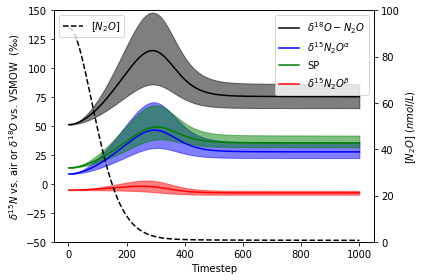

In [7]:
# run the model with a range of isotope effects for N2O consumption
# ...and plot the output, as well as print out the values at the d18O maximum

saveout = pd.DataFrame([],columns=['[NO3-]_uM', 'd15NO3-', 'd18NO3-', '[NO2-]_uM', 'd15NO2-', 'd18NO2-',
   '[N2O]_nM', 'd15N2Oa', 'd15N2Ob', 'd18N2O', 'SP'])

alphas1 = [-3.,6.6,  22.,0., 24.,12.,-2.,10.9, 10.,1.0]
alphas2 = [-3.,11.8,22.,1.6,24.,12.,-2.,20.2,10.,1.0]
alphas3 = [-3.,19.8, 22.,3.4,24.,12.,-2.,30.5, 10.,1.0]

consumptionmax = 0.21
consumptionmin = 0.
consumptionscale = 250

T = 1000
times = np.array(list(range(1,T+1)))

#fig, axlist = plt.subplots(1,2, figsize=(12,4))


inits1 = initialize(alpha_values=alphas1,
                n2o_cons_constants=[consumptionscale,consumptionmax,consumptionmin],
                substrate='NO3-')
inits2 = initialize(alpha_values=alphas2,
                    n2o_cons_constants=[consumptionscale,consumptionmax,consumptionmin],
                    substrate='NO3-')
inits3 = initialize(alpha_values=alphas3,
                    n2o_cons_constants=[consumptionscale,consumptionmax,consumptionmin],
                    substrate='NO3-')

output1 = run_model(inits1)
output2 = run_model(inits2)
output3 = run_model(inits3)

output1['SP'] = output1['d15N2Oa'] - output1['d15N2Ob']
output2['SP'] = output2['d15N2Oa'] - output2['d15N2Ob']
output3['SP'] = output3['d15N2Oa'] - output3['d15N2Ob']

#ax = axlist[count]
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.plot(times,output2.d18N2O,color='k',label=r'$\delta^{18}O-N_2O$')
ax.fill_between(times, output3.d18N2O, output1.d18N2O,
                color='k',alpha=0.5,label=None)

ax.plot(times,output2.d15N2Oa,color='b',label=r'$\delta^{15}N_2O^{\alpha}$')
ax.fill_between(times, output3.d15N2Oa, output1.d15N2Oa,
                color='b',alpha=0.5,label=None)

ax.plot(times,output2.SP,color='g',label=r'SP')
ax.fill_between(times, output3.SP, output1.SP,
                color='g',alpha=0.5,label=None)

ax.plot(times,output2.d15N2Ob,color='r',label=r'$\delta^{15}N_2O^{\beta}$')
ax.fill_between(times, output3.d15N2Ob, output1.d15N2Ob,
                color='r',alpha=0.5,label=None)

ax.set_ylabel(r'$\delta^{15}N$ vs. air or $\delta^{18}O$ vs. VSMOW  ($\perthousand$)')
ax.set_xlabel('Timestep')
ax.legend(loc=1)
ax.set_ylim([-50,150])

ax2 = ax.twinx()

ax2.plot(times,output2['[N2O]_nM'],color='k', linestyle='--', label ='$[N_2O]$')
ax2.set_ylabel(r'$[N_2O]\ (nmol/L)$')
ax2.legend(loc=2)

ax2.legend(loc=2)
ax2.set_ylim([0,100])

s1 = output1[output1.d18N2O == output1.d18N2O.max()]
s2 = output2[output2.d18N2O == output2.d18N2O.max()]
s3 = output3[output3.d18N2O == output3.d18N2O.max()]
 
print('source & {:3.3} &  {:3.3} & {:3.3} & {:4.4} & {:3.3}'.format(float(s3['[N2O]_nM']),
                                                               float(s3['d15N2Oa']),
                                                               float(s3['d15N2Ob']),
                                                               float(s3['d18N2O']),
                                                               float(s3['SP'])))

saveout = saveout.append(output3[output3.d18N2O == output3.d18N2O.max()])

plt.tight_layout()

plt.savefig('Figures/ODZ/production from NO3- with SP.pdf')

source & 2.58 &  60.3 & 2.77 & 148.2 & 57.6
source & 3.04 &  47.7 & -10.1 & 139.2 & 57.9


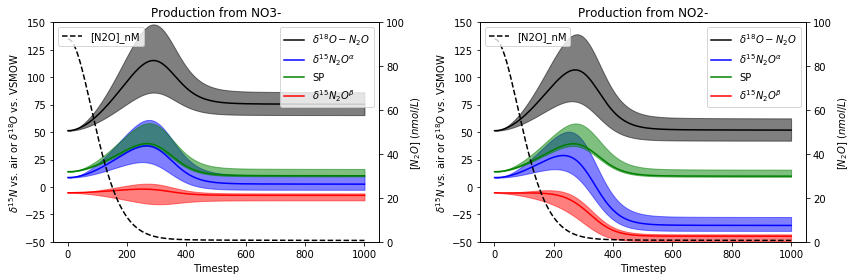

In [9]:
# run the model with a range of isotope effects for N2O consumption
# ...and plot the output, as well as print out the values at the d18O maximum

saveout = pd.DataFrame([],columns=['[NO3-]_uM', 'd15NO3-', 'd18NO3-', '[NO2-]_uM', 'd15NO2-', 'd18NO2-',
       '[N2O]_nM', 'd15N2Oa', 'd15N2Ob', 'd18N2O', 'SP'])

alphas1 = [22.,6.6,  22.,-3., 24.,12.,-2.,10.9, 10.,1.0]
alphas2 = [22.,11.8,22.,1.6,24.,12.,-2.,20.2,10.,1.0]
alphas3 = [22.,19.8, 22.,3.4,24.,12.,-2.,30.5, 10.,1.0]

consumptionmax = 0.21
consumptionmin = 0.
consumptionscale = 250

T = 1000
times = np.array(list(range(1,T+1)))

fig, axlist = plt.subplots(1,2, figsize=(12,4))

for count, s in enumerate(['NO3-','NO2-']):
    
    inits1 = initialize(alpha_values=alphas1,
                    n2o_cons_constants=[consumptionscale,consumptionmax,consumptionmin],
                    substrate=s)
    inits2 = initialize(alpha_values=alphas2,
                        n2o_cons_constants=[consumptionscale,consumptionmax,consumptionmin],
                        substrate=s)
    inits3 = initialize(alpha_values=alphas3,
                        n2o_cons_constants=[consumptionscale,consumptionmax,consumptionmin],
                        substrate=s)

    output1 = run_model(inits1)
    output2 = run_model(inits2)
    output3 = run_model(inits3)

    output1['SP'] = output1['d15N2Oa'] - output1['d15N2Ob']
    output2['SP'] = output2['d15N2Oa'] - output2['d15N2Ob']
    output3['SP'] = output3['d15N2Oa'] - output3['d15N2Ob']
    
    ax = axlist[count]

    ax.plot(times,output2.d18N2O,color='k',label=r'$\delta^{18}O-N_2O$')
    ax.fill_between(times, output3.d18N2O, output1.d18N2O,
                    color='k',alpha=0.5,label=None)

    ax.plot(times,output2.d15N2Oa,color='b',label=r'$\delta^{15}N_2O^{\alpha}$')
    ax.fill_between(times, output3.d15N2Oa, output1.d15N2Oa,
                    color='b',alpha=0.5,label=None)

    ax.plot(times,output2.SP,color='g',label=r'SP')
    ax.fill_between(times, output3.SP, output1.SP,
                    color='g',alpha=0.5,label=None)

    ax.plot(times,output2.d15N2Ob,color='r',label=r'$\delta^{15}N_2O^{\beta}$')
    ax.fill_between(times, output3.d15N2Ob, output1.d15N2Ob,
                    color='r',alpha=0.5,label=None)

    ax.set_ylabel(r'$\delta^{15}N$ vs. air or $\delta^{18}O$ vs. VSMOW')
    ax.set_xlabel('Timestep')
    ax.legend(loc=1)
    ax.set_ylim([-50,150])
    #ax.axhline(50)

    ax2 = ax.twinx()

    ax2.plot(times,output2['[N2O]_nM'],color='k', linestyle='--')
    ax2.set_ylabel(r'$[N_2O]\ (nmol/L)$')
    ax2.legend(loc=2)

    ax2.legend(loc=2)
    ax2.set_title(r'Production from %s' % s)
    ax2.set_ylim([0,100])
    
    s1 = output1[output1.d18N2O == output1.d18N2O.max()]
    s2 = output2[output2.d18N2O == output2.d18N2O.max()]
    s3 = output3[output3.d18N2O == output3.d18N2O.max()]
    
    print('source & {:3.3} &  {:3.3} & {:3.3} & {:4.4} & {:3.3}'.format(float(s3['[N2O]_nM']),
                                                                   float(s3['d15N2Oa']),
                                                                   float(s3['d15N2Ob']),
                                                                   float(s3['d18N2O']),
                                                                   float(s3['SP'])))
    
    saveout = saveout.append(output3[output3.d18N2O == output3.d18N2O.max()])

plt.tight_layout()

plt.savefig('Figures/ODZ/200323 forward model inverse beta.pdf')

#### What isotope effect do you get out if you use the modeled [N2O] and d15Na to calculate the isotope effect for N2O consumption? Does it match the isotope effect that we observe in the data/the one that we put in? ####

See below: If we include only data for which $[N_2O]>40$ nM, then get back out essentially the same isotope effect. The calculated isotope effect changes, however, if we include data down to lower thresholds, or all of the data.

In [10]:
consumptionmax = 0.21
consumptionmin = 0.
consumptionscale = 250

alphas2 = [22.,11.8,22.,1.5,24.,12.,0.,20.2,10.,1.0]
inits2 = initialize(alpha_values=alphas2,
                    n2o_cons_constants=[consumptionscale,consumptionmax,consumptionmin],
                    substrate='NO3-')
output2 = run_model(inits2)

In [17]:
def get_isotope_effect(df, deltaval, ylabel, cutoff, fig, ax):

    df['f'] = df['[N2O]_nM']/df['[N2O]_nM'][0]

    temp = df[df['[N2O]_nM']>cutoff] # isolate values before model runs out at steady state

    x = np.log(temp.f)
    y = np.log(temp[deltaval]+1000)

    xparam = sm.add_constant(x, prepend=False)
    model = sm.OLS(y, xparam)
    result = model.fit()
    m, b = result.params
    merr, berr = result.bse # get standard error of the slope and intercept
    mp, bp = result.pvalues # get p-values for slope and intercept
    rsq = result.rsquared

    cax = ax.scatter(x,y, c=temp['[N2O]_nM'], cmap='coolwarm')
    cax.set_clim([0,80])
    fig.colorbar(cax, label='[N2O] (nmol/L)')

    xplot = np.linspace(x.max(),x.min())
    ax.plot(xplot, xplot*m + b, color='k')
    ax.set_xlabel('ln(f)')
    ax.set_ylabel('ln(%s + 1000)'%ylabel)

    ax.set_xlim(x.max(),x.min())
    textstr = 'y=({:.3})x + {:.2}\n$R^2$={:.2}\n$\epsilon$= {:.3}$\pm${:.3}$\perthousand$'.format(m, 
                b, rsq,m*1000,result.bse[0]*1000)
    ax.text(0.1,0.7,textstr,
            transform=ax.transAxes)
    plt.tight_layout()
    
    return fig, ax

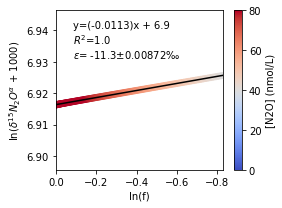

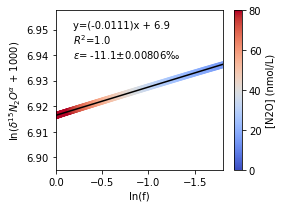

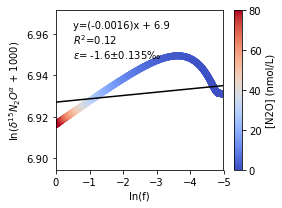

In [18]:
cutoffs = [40,15,0]


for i,c in enumerate(cutoffs):

    fig, ax = plt.subplots(1,1, figsize=(4,3))

    get_isotope_effect(df=output2, deltaval='d15N2Oa', ylabel=r'$\delta^{15}N_2O^{\alpha}$', cutoff=c,
                      fig=fig, ax=ax)
    
    plt.savefig('Figures/isotope_effects/200402_model_alpha_cutoff_{:}.pdf'.format(c))


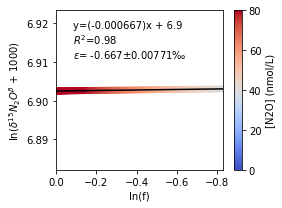

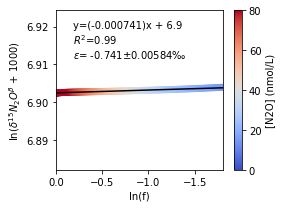

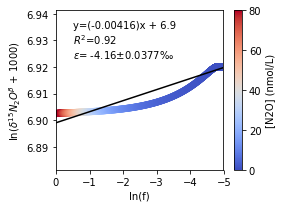

In [19]:
cutoffs = [40,15,0]


for i,c in enumerate(cutoffs):

    fig, ax = plt.subplots(1,1, figsize=(4,3))

    get_isotope_effect(df=output2, deltaval='d15N2Ob', ylabel=r'$\delta^{15}N_2O^{\beta}$', cutoff=c,
                      fig=fig, ax=ax)
    
    plt.savefig('Figures/isotope_effects/200402_model_beta_cutoff_{:}.pdf'.format(c))


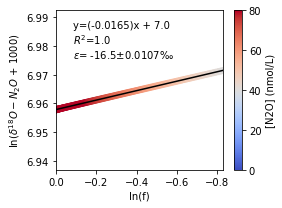

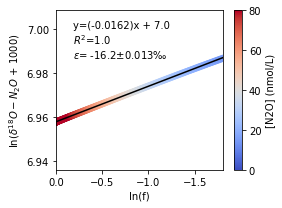

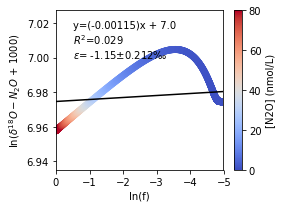

In [20]:
cutoffs = [40,15,0]


for i,c in enumerate(cutoffs):

    fig, ax = plt.subplots(1,1, figsize=(4,3))

    get_isotope_effect(df=output2, deltaval='d18N2O', ylabel=r'$\delta^{18}O-N_2O$', cutoff=c,
                      fig=fig, ax=ax)
    
    plt.savefig('Figures/isotope_effects/200402_model_18O_cutoff_{:}.pdf'.format(c))


#### How sensitive is the model to the parameterization of the N2O consumption curve? ####

Increasing the rate constant and/or DECREASING the scaling factor increase the size of the transient isotope peak and shift it earlier in the model run.

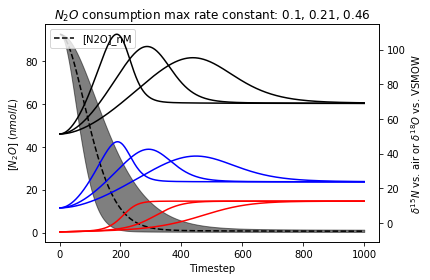

In [15]:
# run the model with a range of isotope effects for N2O consumption
# ...and plot the output, as well as print out the values at the d18O maximum

inits = initialize()

consumptionmaxes = [0.1,0.21,0.46]
consumptionscale = 250

inits1 = initialize(alpha_values=None,
                    n2o_cons_constants=[consumptionscale,consumptionmaxes[0],0.0],
                    substrate='NO3-')
inits2 = initialize(alpha_values=None,
                    n2o_cons_constants=[consumptionscale,consumptionmaxes[1],0.0],
                    substrate='NO3-')
inits3 = initialize(alpha_values=None,
                    n2o_cons_constants=[consumptionscale,consumptionmaxes[2],0.0],
                    substrate='NO3-')

output1 = run_model(inits1)
output2 = run_model(inits2)
output3 = run_model(inits3)

T = 1000
times = np.array(list(range(1,T+1)))

fig, ax = plt.subplots()

ax.plot(times,output2['[N2O]_nM'],color='k', linestyle='--')
ax.fill_between(times,output1['[N2O]_nM'],output3['[N2O]_nM'],color='k', alpha=0.5)

ax.set_ylabel(r'$[N_2O]\ (nmol/L)$')
ax.legend(loc=2)
ax.set_xlabel('Timestep')

ax2 = ax.twinx()

ax2.plot(times,output1.d15N2Oa,color='b',label=r'$\delta^{15}N_2O^{\alpha}$')
ax2.plot(times,output2.d15N2Oa,color='b',label=None)
ax2.plot(times,output3.d15N2Oa,color='b',label=None)

ax2.plot(times,output1.d15N2Ob,color='r',label=r'$\delta^{15}N_2O^{\beta}$')
ax2.plot(times,output2.d15N2Ob,color='r',label=None)
ax2.plot(times,output3.d15N2Ob,color='r',label=None)

ax2.plot(times,output1.d18N2O,color='k',label=r'$\delta^{18}N_2O$')
ax2.plot(times,output2.d18N2O,color='k',label=None)
ax2.plot(times,output3.d18N2O,color='k',label=None)

ax2.set_ylabel(r'$\delta^{15}N$ vs. air or $\delta^{18}O$ vs. VSMOW')
ax2.set_title(r'$N_2O$ consumption max rate constant: 0.1, 0.21, 0.46')

plt.savefig('Figures/sensitivity_tests/200402 N2O cons rate constant sensitivity.pdf')

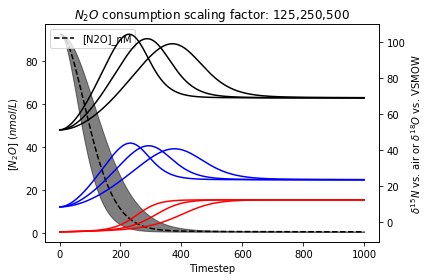

In [16]:
# run the model with a range of isotope effects for N2O consumption
# ...and plot the output, as well as print out the values at the d18O maximum

consumptionmax = 0.21
consumptionscales = [125,250,500]

inits1 = initialize(alpha_values=None,
                    n2o_cons_constants=[consumptionscales[0],consumptionmax, 0.0], substrate='NO3-')
inits2 = initialize(alpha_values=None,
                    n2o_cons_constants=[consumptionscales[1],consumptionmax, 0.0], substrate='NO3-')
inits3 = initialize(alpha_values=None,
                    n2o_cons_constants=[consumptionscales[2],consumptionmax, 0.0], substrate='NO3-')

output1 = run_model(inits1)
output2 = run_model(inits2)
output3 = run_model(inits3)

T = 1000
times = np.array(list(range(1,T+1)))

fig, ax = plt.subplots()

ax.plot(times,output2['[N2O]_nM'],color='k', linestyle='--')
ax.fill_between(times,output1['[N2O]_nM'],output3['[N2O]_nM'],color='k', alpha=0.5)

ax.set_ylabel(r'$[N_2O]\ (nmol/L)$')
ax.legend(loc=2)
ax.set_xlabel('Timestep')

ax2 = ax.twinx()

ax2.plot(times,output1.d15N2Oa,color='b',label=r'$\delta^{15}N_2O^{\alpha}$')
ax2.plot(times,output2.d15N2Oa,color='b',label=r'$\delta^{15}N_2O^{\alpha}$')
ax2.plot(times,output3.d15N2Oa,color='b',label=r'$\delta^{15}N_2O^{\alpha}$')

ax2.plot(times,output1.d15N2Ob,color='r',label=r'$\delta^{15}N_2O^{\beta}$')
ax2.plot(times,output2.d15N2Ob,color='r',label=r'$\delta^{15}N_2O^{\beta}$')
ax2.plot(times,output3.d15N2Ob,color='r',label=r'$\delta^{15}N_2O^{\beta}$')

ax2.plot(times,output1.d18N2O,color='k',label=r'$\delta^{18}N_2O$')
ax2.plot(times,output2.d18N2O,color='k',label=r'$\delta^{18}N_2O$')
ax2.plot(times,output3.d18N2O,color='k',label=r'$\delta^{18}N_2O$')

ax2.set_ylabel(r'$\delta^{15}N$ vs. air or $\delta^{18}O$ vs. VSMOW')
ax2.set_xlabel('Timestep')
ax2.set_title(r'$N_2O$ consumption scaling factor: 125,250,500')
plt.savefig('Figures/sensitivity_tests/200402 N2O cons scaling factor sensitivity.pdf')